In [1]:
import tensorflow as tf

In [2]:
import nltk    
from nltk import tokenize
from nltk.corpus import stopwords

In [3]:
import string

In [4]:
from sklearn.preprocessing import LabelEncoder

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [139]:
from tensorflow.keras.layers import CategoryEncoding

In [6]:
import pandas as pd

In [7]:
import numpy as np

In [8]:
import matplotlib.pyplot as plt

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [155]:
from sklearn.model_selection import train_test_split

In [204]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Embedding

In [10]:
nltk.download('stopwords')
nltk.download('punkt') # Download for word_tokenize
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
df = pd.read_csv("C:\\git\\dados\\nlp\\news_sentiment_analysis.csv", encoding="utf-8")

In [12]:
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business
4,PLANET,NaN,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business


In [81]:
df_news = df[["Description", "Type"]]

In [83]:
MAX_PALAVRAS = 1000

In [85]:
# oov = Out Of Vocabulary
tokenizer = Tokenizer(num_words=MAX_PALAVRAS, oov_token="<UNKNOW>")

In [87]:
def limpar_texto( texto ):
    translator = str.maketrans('–,.!-?()<>[]—', '             ', string.punctuation)
    texto_limpo = texto.translate(translator)
    # return texto_limpo.split(" ")
    return tokenize.word_tokenize(texto_limpo.lower(), language='english')

In [89]:
def limpar_stop_words( tokens ):
    # Remover StopWords
    tokens_limpos = []
    for token in tokens:
        if token not in stop_words: 
            tokens_limpos.append( token )
    return tokens_limpos

In [91]:
def pre_processamento( texto ):
    tokens = limpar_texto( texto )
    tokens_limpos = limpar_stop_words( tokens )
    return " ".join(tokens_limpos)

In [93]:
df_news["tokens"] = df_news["Description"].apply( pre_processamento ) 

C:\Users\anton\AppData\Local\Temp\ipykernel_34152\3805559170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news["tokens"] = df_news["Description"].apply( pre_processamento )


In [95]:
tokenizer.fit_on_texts( df_news["tokens"] )
dicionario = tokenizer.word_index
len(dicionario)

21579

In [97]:
df_news.head()

,Description,Type,tokens
0,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",Business,st george kaitlyn larson firstyear teacher pin...
1,"Harare, Zimbabwe – Local businesses are grappl...",Business,harare zimbabwe local businesses grappling sev...
2,(marketscreener.com) Billionaire Elon Musk has...,Business,marketscreenercom billionaire elon musk donate...
3,(marketscreener.com) A U.S. trade regulator on...,Business,marketscreenercom us trade regulator fridayann...
4,4.5 million households in the U.S. have solar ...,Business,45 million households us solar panels homes cu...


In [157]:
sequencias = tokenizer.texts_to_sequences( df_news["tokens"] )

In [159]:
X = pad_sequences( sequencias, padding="pre" )

In [190]:
X.shape

(3500, 103)

In [163]:
label_encoder = LabelEncoder()

In [165]:
label_numerico = label_encoder.fit_transform( df_news["Type"] )

In [167]:
output_encoder = CategoryEncoding( num_tokens=7, output_mode="one_hot" )

In [182]:
Y = output_encoder( label_numerico ).numpy()
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [184]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

In [212]:
modelo = Sequential()
# modelo.add( Input( (5, 103, ) ) )
modelo.add(Embedding(MAX_PALAVRAS, 32))
modelo.add( SimpleRNN( 32 ) )
modelo.add( Dense( 7, activation="softmax" ) )
modelo.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [214]:
modelo.compile( optimizer="adam", loss="categorical_crossentropy", metrics=["Accuracy"])

In [216]:
historico = modelo.fit( X_train, Y_train, epochs=20, batch_size=32 )

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 201ms/step - Accuracy: 0.2528 - loss: 1.8876
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - Accuracy: 0.5228 - loss: 1.5707
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 193ms/step - Accuracy: 0.6311 - loss: 1.2516
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Accuracy: 0.7718 - loss: 0.9427
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - Accuracy: 0.8388 - loss: 0.6824
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - Accuracy: 0.8797 - loss: 0.5252
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - Accuracy: 0.8954 - loss: 0.4228
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - Accuracy: 0.9330 - loss: 0.3076
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - Accuracy: 0.9487 - loss: 0.2377
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - Accuracy: 0.9476 - loss: 0.2007
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - Accuracy: 0.9560 - loss: 0.1695
Epoch 12/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - A

In [230]:
acuracia = historico.history["Accuracy"] / np.max(historico.history["Accuracy"])
perda = historico.history["loss"] / np.max(historico.history["loss"])

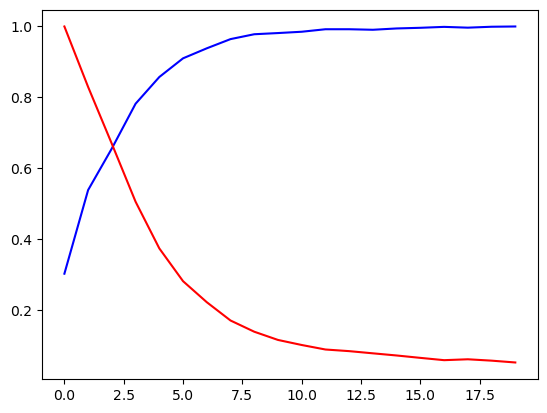

In [232]:
plt.plot(acuracia, color="blue")
plt.plot(perda, color="red")